## Preamble

Questions/comments are prefixed by ''&lt;author&gt;:''.
***

In [1]:
import math, random #Jouke: Do we use the former? Can we not just use numpy for the latter?

from ipywidgets import interact
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Input
from keras.layers import Reshape, UpSampling2D
import numpy as np

import powerlaw
import matplotlib.pyplot as plt
%matplotlib inline

pwl = powerlaw.Power_Law(xmin=1, discrete=True, parameters=[1.9])

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def py(d = 0.1):
    """Something akin to a Pitman-Yor process"""
    members = []
    
    while True:
        if len(members) < 1 or random.random() < d:
            draw = random.normalvariate(0, 1.0)
        else:
            draw = random.choice(members)
            
        yield draw
        members.append(draw)

gen = py(0.01)

def py_init(shape, dtype=None):
    """Custom weight initializer for Keras""" 
    arr = np.fromfunction(lambda *args: args[0]*0.0 + next(gen), shape=shape)
    return arr
#     return K.random_normal(shape, dtype=dtype)

## A Countable Model Class

We want a parameterized class of generative networks as models. The parameter values should such that, via a prefix-free encoding, they induce a _meaningful_ prior on the models. We desire a few properties:
- Every image of $N$ bits (uncompressed) can be generated by a model taking no input and having a prior probability as close to $2^{-N}$ as possible;
- There is a model taking $N$ bits of input such that every image of $N$ bits can be generated by it.

For convenience we may fix the size of the output image and pretend the size, $N$, is known to a model. To be completely thorough, this would add $\log N$ bits to the input of the model. The input of the model is treated as an enumeration of the images generated by it, so strictly speaking the model class should come with a way to scale models to arbitrary input sizes.

A large-ish image size limits the impact of small constants.

In [3]:
# The size of the generated image
height = width = 128
channels = 3

# Let's go with 4 bits per pixel per channel (4096 colors)
uncompressed = height * width * channels * 4

# We divide the uncompressed bits uniformly at random into three types of information
_splits = sorted(np.random.choice(uncompressed - 1, 2, replace=False))
soph = _splits[0] + 1
noise = _splits[1] - _splits[0]
redundancy = uncompressed - 1 - _splits[1]

@interact(_soph=(1, uncompressed - 2), _noise=(1, uncompressed - 2))
def report(_soph=soph, _noise=noise):
    global soph, noise, redundancy
    if _soph + _noise > uncompressed - 1: _noise = uncompressed - _soph - 1
    soph = _soph
    noise = _noise
    redundancy = uncompressed - _soph - _noise
    print('uncompressed  ', uncompressed)
    print('sophistication', soph)
    print('noise         ', noise)
    print('redundancy    ', redundancy)

Widget Javascript not detected.  It may not be installed or enabled properly.


We are now tasked with using `soph` bits to initiate a network that takes `noise` bits as input and generates `uncompressed` bits (shaped correctly) as output.
When choosing the `soph` bits and the `noise` bits randomly, then, with high probability, the generated image has a _sophistication_ and _noise_ close to `soph` and `noise`, respectively.

A typical convolutional neural network (CNN) architecture is `INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC` (http://cs231n.github.io/convolutional-networks/).
In order to generate images from unstructured data, we simply reverse this architecture.
Note that pooling layers are not invertible.
It has been argued that the pooling layers should be replaced by increasing the stride of the convolutions (https://arxiv.org/abs/1412.6806), which suggests a fractional stride for the reverse direction.
A fractional stride is implemented by padding each pixel with zeros (indicative of the loss of information in pooling).
However, a fractional stride executed like this can introduce artifacts (https://distill.pub/2016/deconv-checkerboard/).
Therefore, we choose to invert the pooling layers simply by upscaling.
Although ReLU activation is not invertible per se, no expressive power is lost by using ReLU activation for the reverse direction (but filter weights may need to be adjusted).

Our architecture comes with many hyperparameters that should ideally be parameters of the model class and hence part of the model encoding.
For simplicity, we shall fix them outside the model class and note that the total information represented by the parameters may be low in comparison to the sophistication.
The hyperparameters are

- The number of layers in the fully connected part and for each layer
  - The number of cells;
- The number of convolution blocks and for each block
  - The number of convolutions and for each convolution
    - The size of the filter (height, width, depth);

Upsampling happens after each block of convolutions and is conveniently done by a factor 2 in the height and width.

The hyperparameters determine the number of weights that must be encoded in the sophistication.
Typically, weights in a CNN are not distributed uniformly at random and a trained network can be compressed substantially.
We distinguish two approaches to compressing neural networks:
1. Invasive (e.g. pruning, [LeCun et al., 1989; Guo et al., 2016])
2. Non-invasive (e.g. quantization [Gupta et al., 2015])
The second approach comes in fixed-length and variable-length versions and differs in the amount of reproduction accuracy required accross the literature.
While variable-length and invasive techniques may produce better results, we choose to focus on fixed-length quantization.
If needed, it is possible to account for an additional `X%` improvement obtainable by different methods via an implicit `X/(1-X)%` increase in the available sophistication.

Experiments have shown that weights in a CNN typically follow a Laplace (two-sided exponential) distribution that has lower variance in layers further away from the image.
Quantizing with such a distribution, around 5 bits of accuracy are needed for acceptable performance (http://vijaychan.github.io/Publications/dcc-2017-cnn-compression.pdf).
However, in typical networks (e.g. AlexNet and VGG) the number of weights is dominated by the weights in the fully connected layer, for which our simple quantization scheme is of no use.
In deep convolutional networks (e.g. ResNet), most weights reside in convolutional layers.
We strive to keep the fully connected layer as small as possible, while still realizing the properties we desire of our model class.
In particular, when all information resides in the sophistication, we should resort to a simple fully connected layer where the weight encodes all information in a channel of a pixel (i.e. 4 bits).

It has been observed that CNNs with random filters are able to perform well.
This suggests that information can be pushed to the fully connected layer.
We shall not be too concerned with this and try to put the information in the convolutional layers.

From Wikipedia:
> **Number of filters**
>
> Since feature map size decreases with depth, layers near the input layer will tend to have fewer filters while higher layers can have more.
> To equalize computation at each layer, the feature x pixel position product is kept roughly constant across layers.
> Preserving more information about the input would require keeping the total number of activations (number of feature maps times number of pixel positions) non-decreasing from one layer to the next.

### Quick and Dirty

Let's ignore the fully connected layer for a moment.
There are roughly `soph // 5` weight variables available (drawn from Laplace distributions with varying variance), assuming 5 bits per weight.

The size of the output image is `height * width * channels`, whereas, ideally, the input is `1 * 1 * noise`.
Suppose we keep the kernel size fixed throughout the network (**`kernelsize`**) and let the depth of each convolution layer increases exponentially from the image towards the input (**`depthfactor`**), thus decreases with a factor `1 / depthfactor` towards the image.

This allows us to calculate the number of weights in the `i`th convolution layer from the image:

```kernelsize ** 2 * channels * depthfactor ** (i - 1) * channels * depthfactor ** i```

If their are `depth` convolution layers in the network, this amounts to a total number of weights of

```kernelsize ** 2 * channels ** 2 * depthfactor / (depthfactor ** 2 - 1) * [depthfactor ** (2 * depth) - 1]```

For convenience we match the depth of the input to `channels * depthfactor ** depth`, meaning that it may end up not being sized `1 * 1 * noise`.
Importantly, we must have `height / 2 ** depth <= sqrt(noise / (channels * depthfactor ** depth))`.
Additionally, we should demand `height >= sqrt(noise / (channels * depthfactor ** depth))` to hold.
This assumes we upsample at most every convolution layer and that we upsample with a factor of 2 in both height and width.

### Assumptions
- we keep the kernelsize constant throughout the network
- we distribute the upsampling steps evenly throughout the network
- the filterdepth decreases by a constant factor in every block
- we treat the noise as a bitstring instead of as a string of, say, 4 bit words

In [4]:
def number_of_weights(kernelsize, depth, depthfactor):
    """total number of weights in a network with the given hyperparameters"""
    return kernelsize**2 * channels**2 * depthfactor * (depthfactor**(2 * depth) - 1) / (depthfactor**2 - 1)

def depth_to_factor(weights, kernelsize, depth):
    """find a depthfactor corresponding to a depth given the number of weights"""
    # Test the degenerate limit case where depthfactor = 1
    if kernelsize**2 * channels**2 * depth > weights: return None
    PRECISION = 30
    low, high = (0.0, 1.0)
    for _ in range(PRECISION):
        candidate = (low + high) / 2
        candidate_weights = number_of_weights(kernelsize, depth, 1 / candidate)
        if candidate_weights < weights: high = candidate
        else: low = candidate
    # Last known depthfactor guaranteed to not generate too many weights
    return 1 / high

In [5]:
# We use quantization based on a Laplace distribution, resulting in a reduced number of Bits Per Weight
# NB: for optimal results, the variance of the distribution should vary throughout the network
bpw = 5
weights = soph / bpw

_kernelsize = 5
_depth = 1
while True:
    _depthfactor = depth_to_factor(weights, _kernelsize, _depth)
    if _depthfactor is None: break
    _reshapesize = np.sqrt(noise / (channels * _depthfactor**_depth))
    if height >= _reshapesize and height / 2**_depth <= _reshapesize:
        print('Possible depth:', _depth)
        _blockdepth = _depth # remember last possible depth
    _depth += 1

# FIXME: We take the last depth value and assume we need to reshape the noise to the image dimensions.
#        This elliminates the need for reshaping and does not make a lot of conceptual sense.
#        The reason to do so is that we can at least (hopefully) get some pictures to look at.

# Out-of-band parameters
kernelsize = _kernelsize
blockdepth = _blockdepth # (FIXME)
print('weights     ', weights)
print('kernelsize  ', kernelsize)
print('blockdepth  ', blockdepth)

# Derived parameters
numblocks = 1 # (FIXME)
reshapesize = height # (FIXME)
reshapedepth = max(int(np.ceil(noise / reshapesize**2)), channels)
depthfactor = (reshapedepth / channels)**(1 / (blockdepth * numblocks))
print('numblocks   ', numblocks)
print('reshapesize ', reshapesize)
print('reshapedepth', reshapedepth)
print('depthfactor ', depthfactor)

Possible depth: 2
Possible depth: 3
Possible depth: 4
Possible depth: 5
Possible depth: 6
Possible depth: 7
Possible depth: 8
Possible depth: 9
Possible depth: 10
Possible depth: 11
Possible depth: 12
Possible depth: 13
Possible depth: 14
Possible depth: 15
Possible depth: 16
Possible depth: 17
Possible depth: 18
Possible depth: 19
Possible depth: 20
Possible depth: 21
Possible depth: 22
Possible depth: 23
Possible depth: 24
Possible depth: 25
Possible depth: 26
Possible depth: 27
Possible depth: 28
Possible depth: 29
Possible depth: 30
Possible depth: 31
Possible depth: 32
Possible depth: 33
Possible depth: 34
Possible depth: 35
Possible depth: 36
weights      17067.6
kernelsize   5
blockdepth   36
numblocks    1
reshapesize  128
reshapedepth 6
depthfactor  1.0194406437021448


In [6]:
def initializer_laplace(shape, dtype=None):
    """Samples from a laplace distribution"""
    # TODO:
    # - truncate precision to `bpw` bits
    # - vary variance
    return np.random.laplace(size=shape)

x = encoded = Input(shape=(reshapesize, reshapesize, reshapedepth))
for block in range(numblocks - 1): # One too few
    for i in range(blockdepth):
        x = Conv2D(int(np.ceil(reshapedepth / depthfactor ** (block * blockdepth + i + 1))),
                   (kernelsize, kernelsize),
                   activation='relu', padding='same', kernel_initializer=initializer_laplace)(x)
    x = UpSampling2D((2, 2))(x)
for i in range(blockdepth): # The remaining one (without upsampling)
    x = Conv2D(int(np.ceil(reshapedepth / depthfactor ** ((numblocks - 1) * blockdepth + i + 1))),
               (kernelsize, kernelsize),
               activation='relu', padding='same', kernel_initializer=initializer_laplace)(x)

# Bring the outputs inside [0, 1] (TODO: 4 bits per channel discretization)
decoded = Activation('sigmoid')(x)

decoder = Model(encoded, decoded)

decoder.summary()
print('The number of parameters should be reasonably close to the '
      'number of weights available from the sophistication')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 6)       906       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 6)       906       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 6)       906       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 6)       906       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 6)       906       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 6)       906       
__________

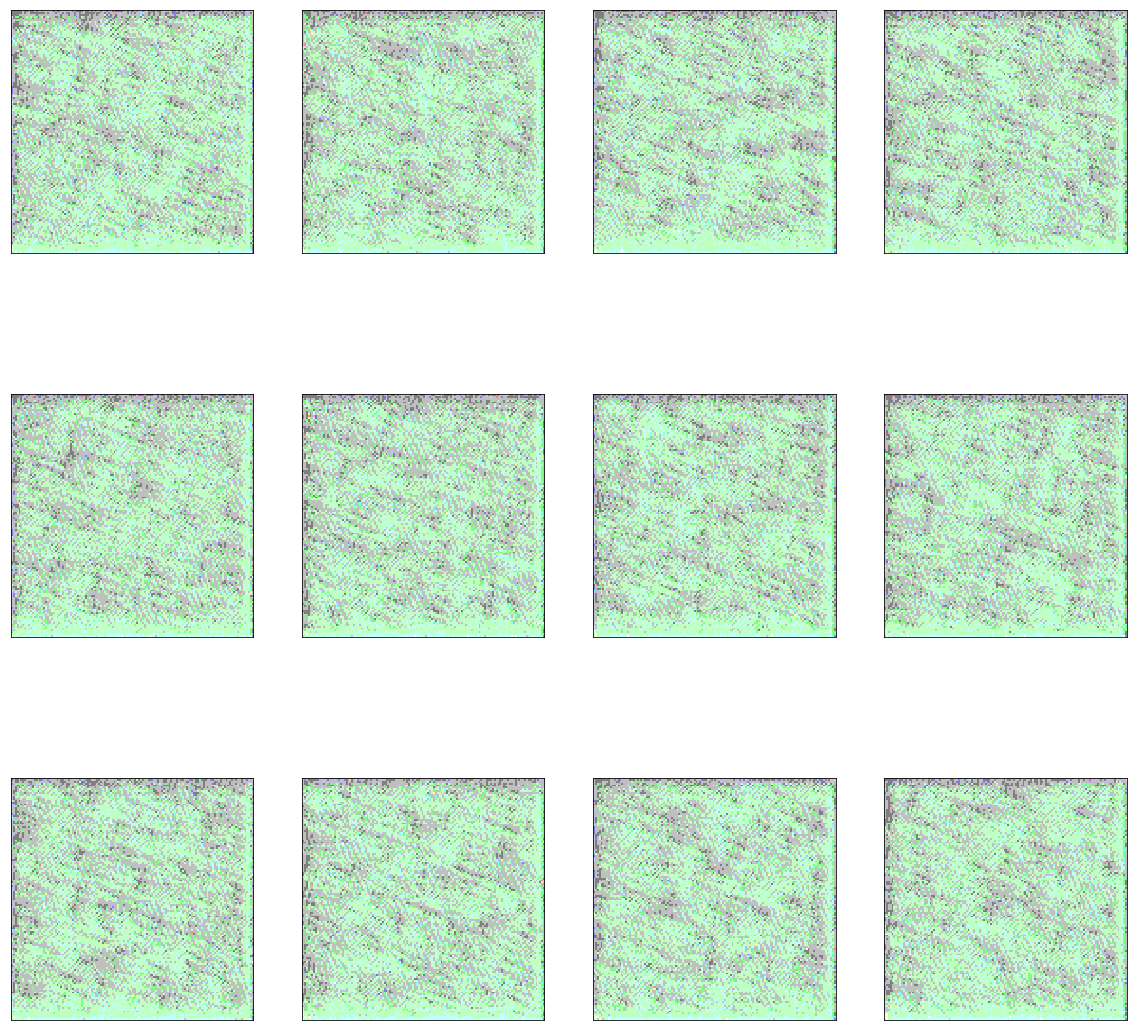

In [7]:
n = 12

z = np.random.choice(2, (n, reshapesize, reshapesize, reshapedepth))
y = decoder.predict(z, batch_size=n)

fig = plt.figure(figsize=(20, 20))
for i in range(n):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(y[i,...])

### Peter's Model

Currently, the topology is a series of `numblocks` stacks of `blockdepth` consecutive 2D convolutions, separated by upsampling layers.
There is also a dense layer following the input.
This topology is fairly standard (http://cs231n.github.io/convolutional-networks/).

**Questions Jouke has**:
- To what extent is a this standard network layout (`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`, see the above Stanford link) theoretically invertible?
- What is the difference between convolutions and transpose convolutions (from https://arxiv.org/pdf/1603.07285.pdf I understand that each can be expressed as the other), and why do we prefer the former?

In [8]:
# Sample a model

# number of blocks of k convolutions and 
input_dim = int(pwl.generate_random()[0])
print('input_dim\t', input_dim)

num_channels = int(pwl.generate_random()[0])
print('num_channels\t', num_channels)

numblocks = random.randint(1,13) # this should be unbounded for a proper model class
print('numblocks\t', numblocks)

blockdepth = random.randint(1,7)
print('blockdepth\t', blockdepth)

kernelsize = random.randint(1,10)
print('kernelsize\t', kernelsize)



input_dim	 2
num_channels	 1
numblocks	 3
blockdepth	 1
kernelsize	 5


In [9]:
# Reset the PY weight generator
# gen=py(0.2)

encoded = Input(shape=(input_dim,))

x = Dense(256, activation='relu')(encoded)
x = Reshape((4,4,16))(x)

for n in range(numblocks):
    for b in range(blockdepth):
        x = Conv2D(num_channels, (kernelsize, kernelsize), activation='relu', padding='same', kernel_initializer=py_init)(x)
        
    x = UpSampling2D((2, 2))(x)
        
decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

decoder = Model(encoded, decoded)

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 4, 4, 1)           401       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 1)           26        
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 1)         0         
__________

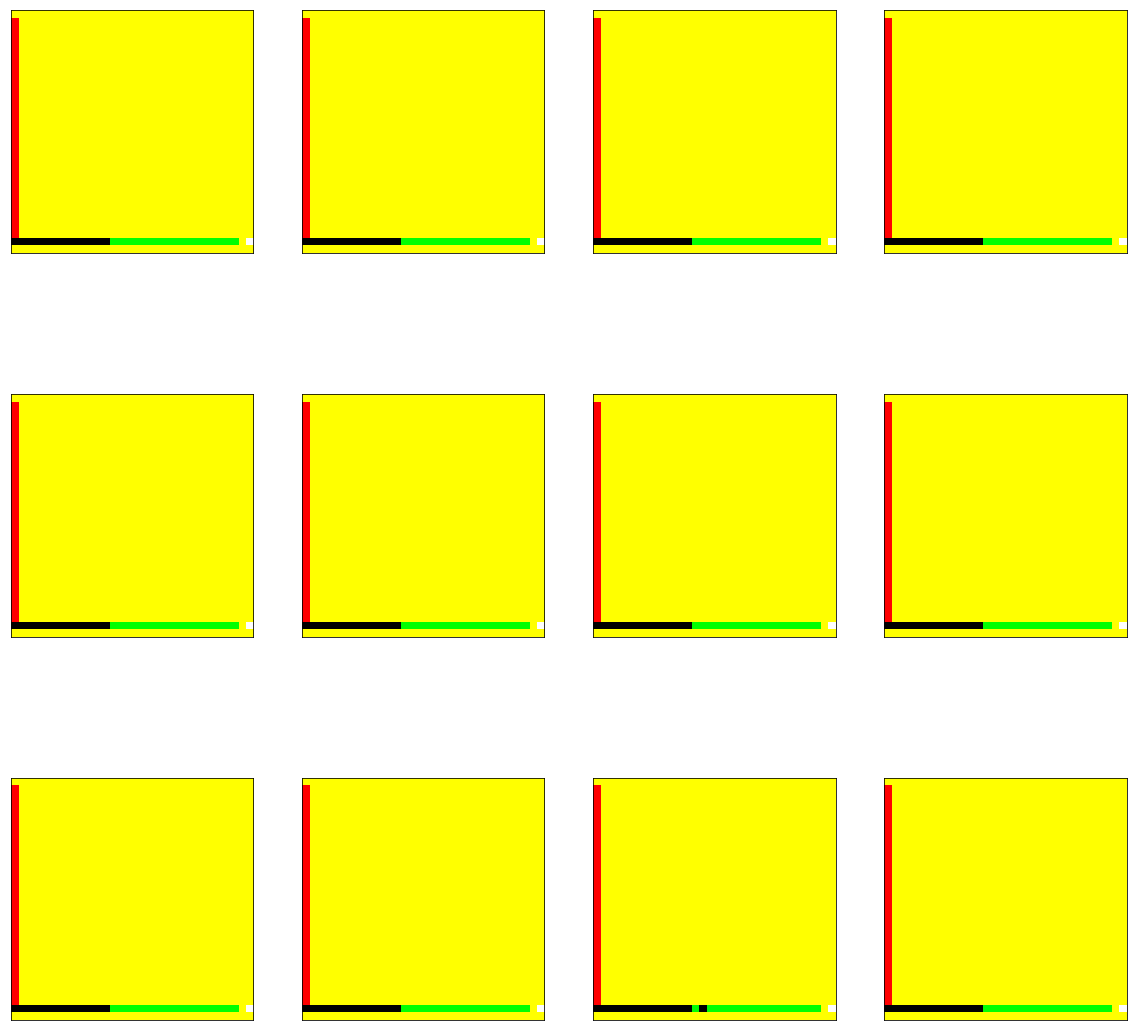

In [10]:
n = 12

z = np.random.randn(n, input_dim) #Jouke: why take a normal distribution over the input?
y = decoder.predict(z)

fig = plt.figure(figsize=(20, 20))
# plot several images
for i in range(n):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(y[i,...])
    
plt.savefig('random-images.pdf')